## Introduction

For this project, I am going to attempt to predict the price of Bitcoin. The data I am using is taken from coindesk which offers a REST API allowing me to obtain a dataset showing daily Bitcoin price in USD. 

### A bit about Bitcoin...

Bitcoin was launched in 2009 and at the beginning the price was very low until the value began to increase in 2010. Throughout its life, Bitcoin has been extremely volatile in value, experiencing huge inflation and subsequent crashes. It is generally considered the most prominient cryptocurrency although does ave some strong competetors.

Bitcoin is based on a blockchain,  a public ledger containing all  transactions in the bitcoin network. This eliminates the need for any central authority and enables transaction to take place without trust between the two parties. Users can mine for bitcoins by solving problems using compute power that make the network secure. The compute cost of mining bitcoin is extremely high, requiring specialised equipment. 

The are many factors which can impact the price of Bitcoin, and given its relatively short lifespan its difficult to tell how large financial or market events could impact it. Like all currency, supply and demand is a key factor. Given the high electricity requirements to produce Bitcoin, increased energy costs can mean that the production of bitcoin slows and reduces supply (increasing the price). The total number of bitcoins that can ever be in existance is 21m. The supply of bitcoin reached 18.1 million in December 2019, representing 86.2% of the supply of bitcoin that will ever be  available. Once 21 million bitcoins are in circulation, prices depend on whether it is considered practical (readily usable in transactions), legal, and in demand. This means that any regulation of bitcoin could have a big impact. Finally, bitcoin has an inbuilt mechanism that acts like an artifical inflator, called halving. Halving occurs rughly every 4 years, where the reward that miners recive for their activity is halved. This reduces the number of coins available, having an inflatory effect on the price.

### Time series forecasting the Bitcoin price

To predict the future price of Bitcoin, I will use an ARIMA model (Auto Regressive Integrated Moving Average). In order to use ARIMA, the data I am working with must be stationary (e.g. mean and standard deviation stays the same). I may need to make some transformations to the data to acheive this.


## Getting The Data

In [4]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import requests
from datetime import datetime, timedelta, date
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm_notebook
from itertools import product
#import statistics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
# Get data and remove the columns we dont need

today = str(date.today())
response =requests.get(' https://api.coindesk.com/v1/bpi/historical/close.json?start=2016-08-01&end=' + today).json()
df = pd.DataFrame.from_dict(response)
df = df.drop(['disclaimer','time'], axis = 1).dropna()
display(df)

,bpi
2016-08-01,607.3740
2016-08-02,552.8210
2016-08-03,565.2638
2016-08-04,578.3213
2016-08-05,574.9563
...,...
2020-09-05,10439.5000
2020-09-06,10110.4400
2020-09-07,10164.1300
2020-09-08,10316.5833


## Exploring The Data

In [6]:
df.describe()

,bpi
count,1487.000000
mean,6140.313243
std,3700.288439
min,552.821000
25%,3227.790400
50%,6548.330000
75%,8901.338350
max,19343.040000


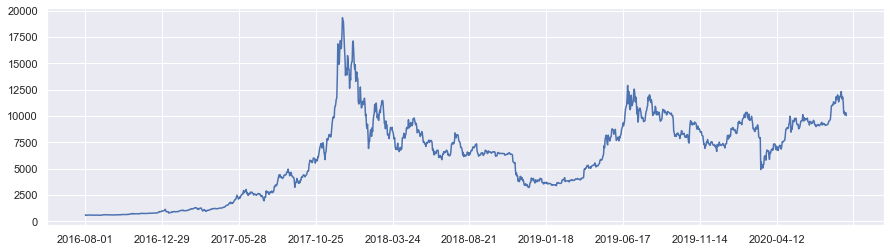

In [7]:
#Plot the data to see the trend over time
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(111)
lines = ax1.plot(df.bpi)
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

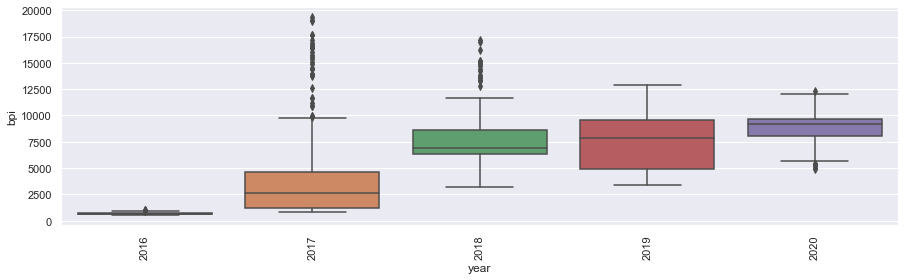

In [8]:
#investigate the variance each year
df['year'] = pd.DatetimeIndex(df.index).year

fig, axes = plt.subplots(figsize=(15, 4))
ax = sns.boxplot(data = df, x='year',y=('bpi'))
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

## Check If The Data Is Stationary

Explain

Augmented Dickey Fuller Test: Low P-value indicates data is stationary

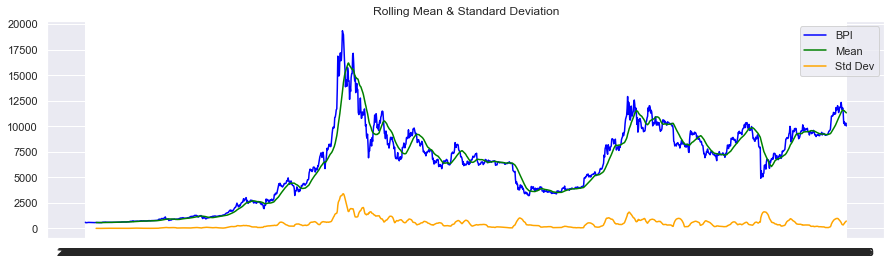

ADF Stat: -2.272622
P-value: 0.180950
The graph is non stationary


In [9]:
#Testing if the data is stationary
from statsmodels.tsa.stattools import adfuller

def test_stationary(x):
    
    #Get rolling stats
    rollingmean = x.rolling(window = 22, center=False).mean()
    rollingstd = x.rolling(window = 22, center=False).std()
    
    #Plot rolling stats
    plt.figure(figsize=(15, 4))
    orig = plt.plot(x, color = 'blue', label = 'BPI')
    mean = plt.plot(rollingmean, color = 'green', label = "Mean")
    std = plt.plot(rollingstd, color = 'orange', label = 'Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    #Dickey Fuller Test
    result=adfuller(x)
    print('ADF Stat: %F'%result[0])
    print('P-value: %F'%result[1])
    pvalue = result[1]
    for key, value in result[4].items():
        if result[0]>value:
            print ('The graph is non stationary')
            break
        else:
            print('The graph is stationary')
            break;
        print('Critical values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

data = df['bpi']
test_stationary(data)

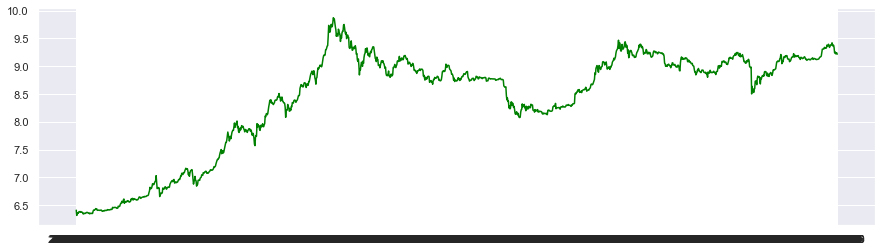

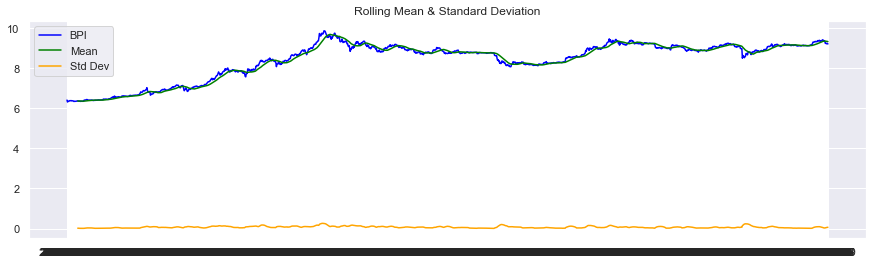

ADF Stat: -2.135949
P-value: 0.230307
The graph is non stationary


In [11]:
#Log transforming the data and test again to see if stationary
data_log = np.log(data)
plt.figure(figsize=(15, 4))
plt.plot(data_log, color = 'green')
plt.show()

test_stationary(data_log)


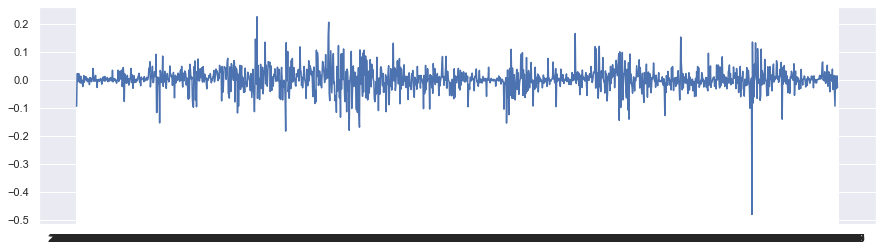

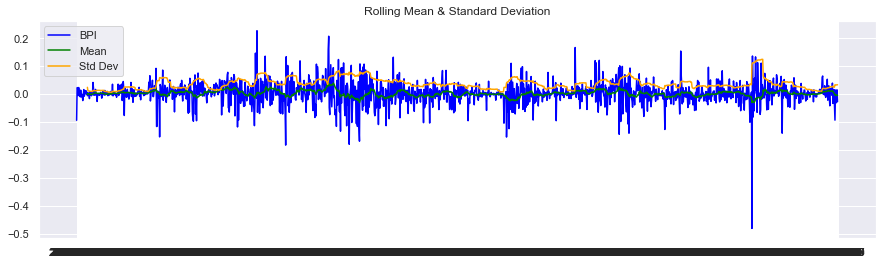

ADF Stat: -26.679144
P-value: 0.000000
The graph is stationary


In [12]:
#Remove trend and seasonality from the data using time shifting (subtract every point from the one that preceeded it) and test again to see if its stationary

data_log_diff = data_log - data_log.shift()
plt.figure(figsize=(15, 4))
plt.plot(data_log_diff)
plt.show()

data_log_diff.dropna(inplace = True)
test_stationary(data_log_diff)

## Setting model parameters

ACF and PACF

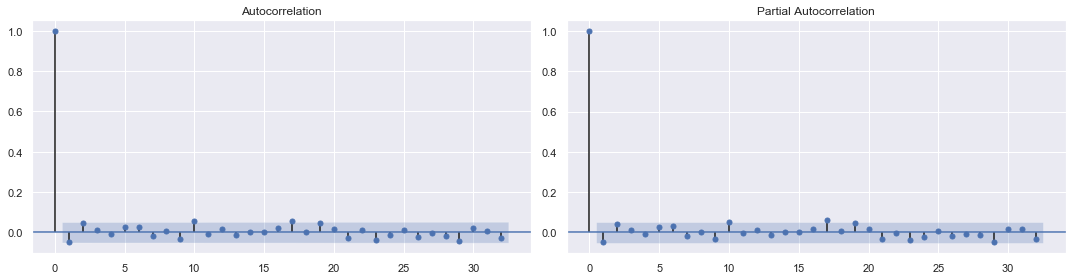

In [17]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,4))
ax = plt.subplot(121)
sm.graphics.tsa.plot_acf(data_log_diff.values.squeeze(), ax=ax)
ax = plt.subplot(122)
sm.graphics.tsa.plot_pacf(data_log_diff.values.squeeze(), ax=ax)
plt.tight_layout()
plt.show()

## Model

In [14]:
#Create train and test datasets
data_log_diff.dropna(inplace = True)
size = int(len(data_log_diff)*0.7)
train, test = data_log_diff[0:size], data_log_diff[size:len(data)]
p = 2
d = 1
q = 0


history = [x for x in train]
predictions = list()
error_list = list()
originals = list()

# build model
model = ARIMA(history, order=(p, d, q))
model_fit = model.fit(disp=-1)
    
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1039
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1693.853
Method:                       css-mle   S.D. of innovations              0.047
Date:                Tue, 29 Sep 2020   AIC                          -3379.707
Time:                        19:00:47   BIC                          -3359.923
Sample:                             1   HQIC                         -3372.201
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.857e-05      0.001      0.067      0.947      -0.001       0.001
ar.L1.D.y     -0.6954      0.029    -23.707      0.000      -0.753      -0.638
ar.L2.D.y     -0.3318      0.029    -11.319      0.0

In [15]:
#Fit and test model
for t in range(len(test)):
    
    # fit model
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    

    #get the prediction from the output and append to predictions list
    pred_val = output[0]
    predictions.append(pred_val)
    
    #get the original value and append to history
    orig_val = test[t]
    history.append(orig_val)
    originals.append(orig_val)
    
    
    # Calculate the error
    error = ((abs(pred_val - orig_val)) / orig_val) * 100
    error_list.append(error)
    
    #print results
    print('predicted=%f, expected=%f, error=%f' % (pred_val, orig_val, error))
    
    
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')


predicted=0.013224, expected=-0.009132, error=-244.807418
predicted=0.007133, expected=-0.037772, error=-118.883206
predicted=-0.006630, expected=0.048829, error=113.578946
predicted=-0.001834, expected=-0.012906, error=-85.788492
predicted=0.001330, expected=0.032260, error=95.878533
predicted=0.021418, expected=0.007241, error=195.794743
predicted=0.009764, expected=0.054486, error=82.080108
predicted=0.030001, expected=0.018611, error=61.199136
predicted=0.028070, expected=0.013397, error=109.523689
predicted=0.029040, expected=0.039719, error=26.885082
predicted=0.023226, expected=-0.027839, error=-183.432589
predicted=0.010604, expected=0.022287, error=52.418452
predicted=0.009837, expected=0.026690, error=63.142682
predicted=0.007059, expected=0.070138, error=89.935693
predicted=0.038567, expected=0.044201, error=12.747297
predicted=0.048052, expected=0.015351, error=213.016624
predicted=0.044177, expected=0.016531, error=167.243200
predicted=0.025365, expected=0.062388, error=59


 Mean Error in Predicting Test Case Articles : -24.655778  %


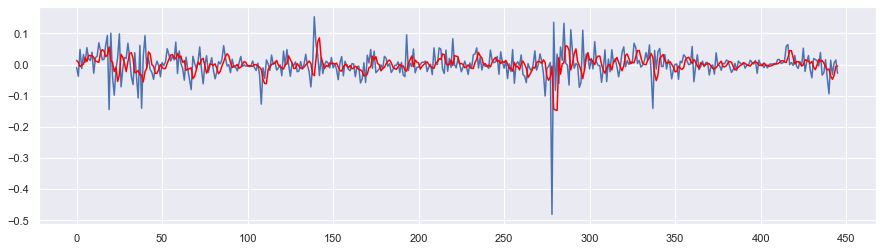

In [16]:
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')

#plot
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(111)
testline = ax1.plot(originals)
predictline = ax1.plot(predictions, color='red')
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

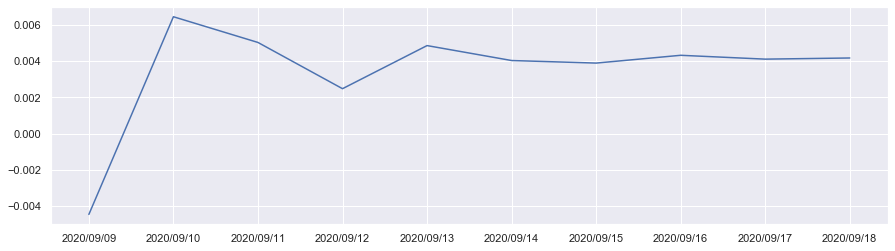

In [18]:
days = 10
dates = []

for i in range(days):
    lastdate = datetime.strptime(max(df.index), "%Y-%m-%d")
    newdate = lastdate + timedelta(days=i)
    newdate = datetime.strftime(newdate, "%Y/%m/%d")
    dates.append(newdate)
    i = i +1
    
forward = model_fit.forecast(days)
dct = dict(zip(dates, forward[0]))
forecast = pd.DataFrame.from_dict(dct, orient='index',columns=['Prediction'])

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(111)
line = ax1.plot(forecast)
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.show()

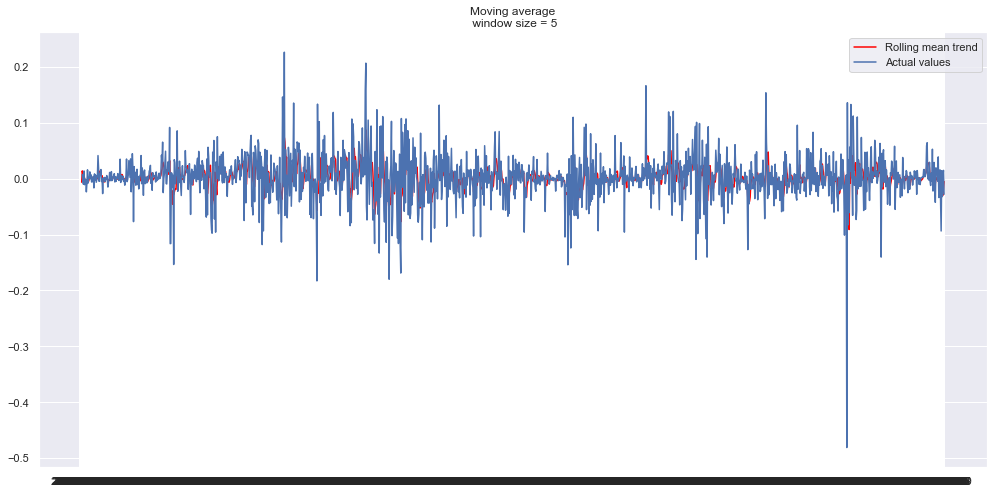

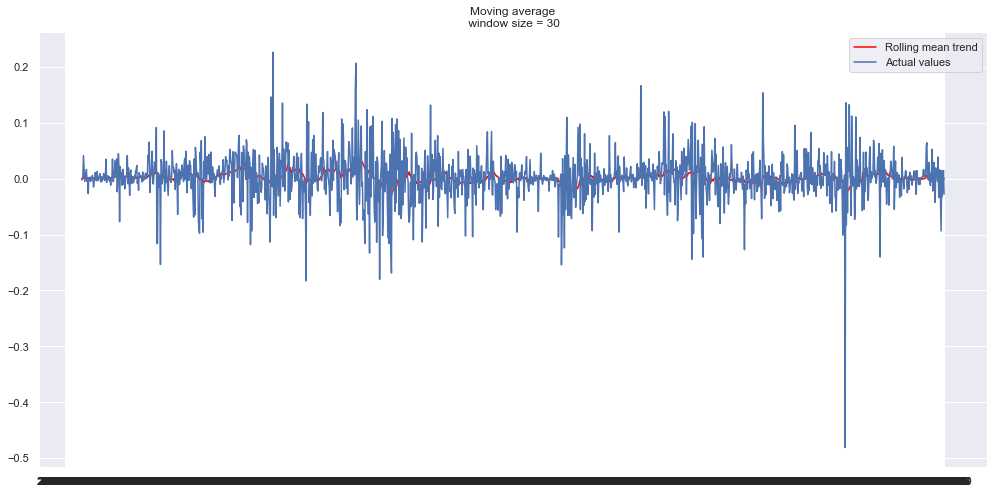

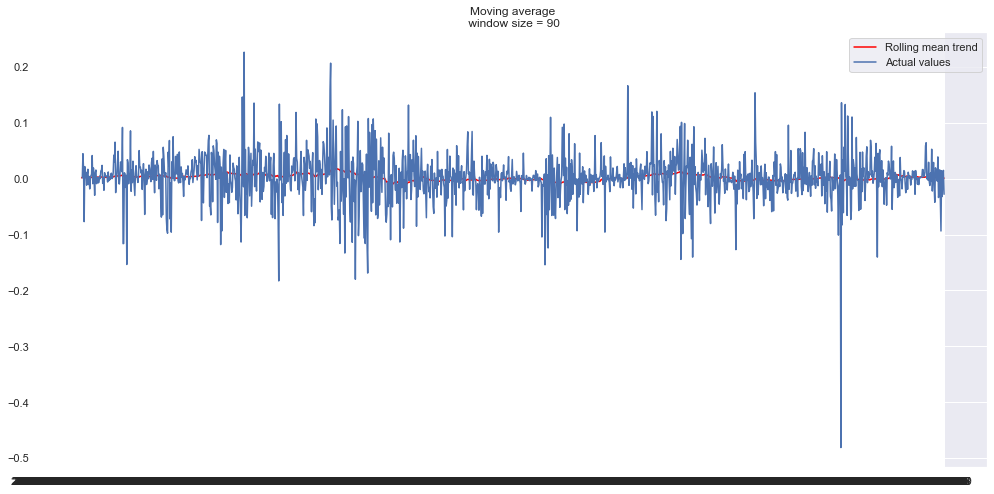

In [19]:
#moving average model

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'red', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data_log_diff, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data_log_diff, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data_log_diff, 90)
